In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# 1. Load the data

In [2]:
df = pd.read_csv('Kaggle-Give-Me-Some-Data/cs-training.csv')

In [3]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=1)

# 2. Data Preprocessing

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
preprocessor = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),    # fill missing values with median
                               ('scaler', StandardScaler())])   # standardize the data

# 3. Demetionality Reduction

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(preprocessor.fit_transform(X_train))
pca.explained_variance_ratio_

array([0.29951933, 0.15335769, 0.12368526, 0.10203644, 0.09971611,
       0.09259887, 0.07239249, 0.05431415, 0.00170543, 0.00067423])

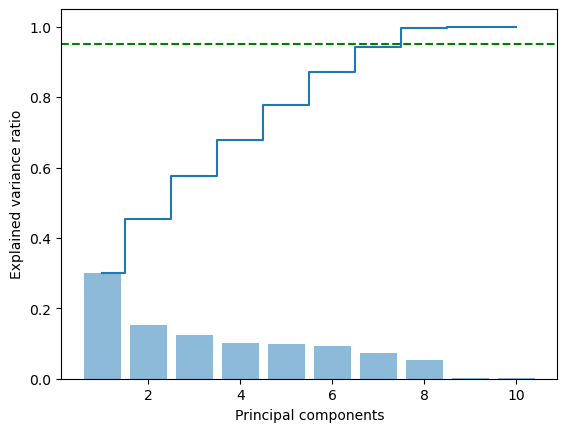

In [8]:
plt.bar(range(1, pca.explained_variance_ratio_.shape[0]+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, pca.explained_variance_ratio_.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.axhline(0.95, color='green', linestyle='--')
plt.show()

We can see that the first 8 principal components explain about 95% of the variance in the data, so we use 8 principal components for the model.

# 4. Model

In [9]:
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('pca', PCA(n_components=8)), 
                          ('classifier', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.933


# 5. parameter tuning

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5)   # make sure the class distribution is similar in each fold

pipe_lr_tune = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('pca', PCA()), 
                               ('classifier', LogisticRegression(random_state=1))])
param_grid = {'pca__n_components': [6, 8, 10],  
              'classifier__C': [10**i for i in range(-4, 4)], 
              'classifier__penalty': ['l2'],
              'classifier__solver': ['sag']}
gs = GridSearchCV(estimator=pipe_lr_tune, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=kfold,
                  verbose=2,
                  n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('impute',
                                                         SimpleImputer(strategy='median')),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('pca', PCA()),
                                       ('classifier',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                           1000],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['sag'],
                         'pca__n_components': [6, 8, 10]},
             scoring='accuracy', verbose=2)

In [11]:
print('Best Accuracy: %.4f' % gs.best_score_)

Best Accuracy: 0.9333


In [12]:
print('Best Parameters: %s' % gs.best_params_)

Best Parameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'sag', 'pca__n_components': 6}


In [13]:
print('Test Accuracy: %.4f' % gs.score(X_test, y_test))

Test Accuracy: 0.9334
